In [1]:
import cv2
import numpy as np
import dask as d
import matplotlib.pyplot as plt
import time
import keras_tuner as kt

from glob import glob
from tensorflow import test, device
# from tensorflow import keras 
from tensorflow.keras import backend, Input, Model, layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, MeanIoU
from tensorflow.keras.optimizers import RMSprop

In [2]:
from fl_tissue_model_tools import defs, models
import fl_tissue_model_tools.preprocessing as prep

In [3]:
data_root_path = "D:/oxford_pets_data" # Carson
# data_root_path = "./" # Mitchell

In [4]:
img_paths = sorted([fn.replace("\\", "/") for fn in glob(f"{data_root_path}/images/*.jpg")])
label_paths = sorted([fn.replace("\\", "/") for fn in glob(f"{data_root_path}/annotations/trimaps/[!._]*.png")])

# Validate images match labels in order & count

In [5]:
def get_img_id(img_path):
    return img_path.split("/")[-1].split(".")[0]

In [6]:
assert(all([get_img_id(img_paths[i]) == get_img_id(label_paths[i]) for i in range(len(img_paths))]))

In [7]:
assert(len(img_paths) == len(label_paths))
print(len(img_paths))

7390


# Constants

In [8]:
rand_seed = 12345
batch_size = 32
img_shape = (128, 128)
# img_size = (160, 160)
# num_classes = 2
n_outputs = 1
rs = np.random.RandomState(seed=rand_seed)
# For collapsing mask into binary range
fg_vals = [1, 3]
bg_vals = [2]
cp_filepath = "oxford_pets_segmentation_best_weights.h5"
cls_thresh = 0.5
filter_counts_options = [
    (8, 16, 32, 64),
    (16, 32, 64, 128),
    (32, 64, 128, 256)
]

# Examine data

In [9]:
preview_idx = 10

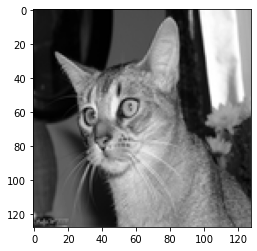

In [10]:
# img = cv2.imread(img_paths[preview_idx], cv2.IMREAD_GRAYSCALE)
img = np.expand_dims(np.array(load_img(img_paths[preview_idx], target_size=img_shape, color_mode="grayscale", interpolation="lanczos")), 2)
plt.imshow(img, cmap="gray")
plt.show()

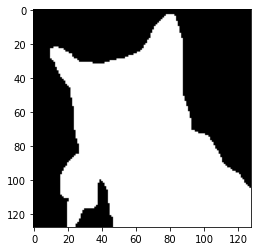

In [11]:
mask = np.expand_dims(
    np.array(load_img(label_paths[preview_idx], target_size=img_shape, color_mode="grayscale", interpolation="nearest")), 2
)
mask = prep.map2bin(mask, fg_vals, bg_vals)
plt.imshow(mask, cmap="gray")
plt.show()

In [12]:
np.unique(mask)

array([0, 1], dtype=uint8)

# Data pipeline

In [13]:
def load_y(batch_label_paths, img_shape, fg_vals=fg_vals, bg_vals=bg_vals):
    # load the target images and condense the number of labels in the segmentation mask
    y = np.zeros((len(batch_label_paths),) + img_shape + (1,), dtype=np.uint8)
    for j, path in enumerate(batch_label_paths):
        # Use interpolation="nearest" to ensure mask is only valid bit values
        img = load_img(path, target_size=img_shape, color_mode="grayscale", interpolation="nearest")
        # add a third dimension to the array
        img = np.expand_dims(img, 2)
        # Collapse the mask from three labels to two labels
        img = prep.map2bin(img, fg_vals, bg_vals)
        y[j] = img
    return y


def load_x(batch_img_paths, img_shape):
    # Load the input images and convert them to grayscale
    x = np.zeros((len(batch_img_paths),) + img_shape + (1,), dtype=np.float32)
    for j, path in enumerate(batch_img_paths):
        # Ensure best quality downsampling (interpolation methods overview: https://stackoverflow.com/a/44083113)
        img = load_img(path, target_size=img_shape, color_mode="grayscale", interpolation="lanczos")
        img = np.expand_dims(img, 2) # add a third dimension to the array
        x[j] = img
    return x


class BinaryMaskSequence(Sequence):
    """Helper to iterate over the data"""
    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, random_state, load_x, load_y, fg_val=1, bg_val=0, sample_weights=None, augmentation_function=None):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.rs: np.random.RandomState = random_state
        self.load_x = load_x
        self.load_y = load_y
        self.fg_val = fg_val
        self.bg_val = bg_val
        self.sample_weights = sample_weights
        if sample_weights:
            self.fg_weight = sample_weights[self.fg_val]
            self.bg_weight = sample_weights[self.bg_val]
        self.augmentation_function = augmentation_function

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        """Returns the batch (input, target) at index `idx`"""
        # Image index, offset by batch
        i = idx * self.batch_size 
        
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x, y = d.compute((d.delayed(self.load_x)(batch_input_img_paths, self.img_size), d.delayed(self.load_y)(batch_target_img_paths, self.img_size)))[0]
        
        if self.augmentation_function != None:
            x, y = self.augmentation_function(x, y, self.rs)

        # If want to up/down-weight foreground/background pixel loss
        # This is good for images that tend to be imbalanced between foreground
        # and background pixel area.
        if self.sample_weights:
            batch_sample_weights = np.zeros(shape=y.shape)
            batch_sample_weights[y == self.fg_val] = self.fg_weight
            batch_sample_weights[y != self.fg_val] = self.bg_weight
            return x, y, batch_sample_weights
            
        return x, y

# Data generator demo

0.15099573135375977


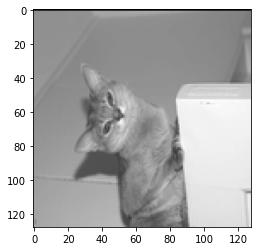

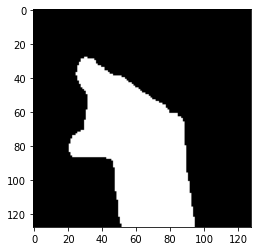

In [14]:
# pets_demo = data_prep.BinaryMaskSequence(batch_size, img_shape, img_paths, label_paths, rs, load_x, load_y, augmentation_function=augment_data)
pets_demo = BinaryMaskSequence(batch_size, img_shape, img_paths, label_paths, rs, load_x, load_y, augmentation_function=prep.augment_img_mask_pairs)
start = time.time()
X, y = pets_demo[1]
stop = time.time()
print(stop - start)
plt.imshow(X[1][:,:,0], cmap='gray')
plt.show()
plt.imshow(y[1][:,:,0], cmap='gray')
plt.show()

# Set up data generators

In [15]:
n_val = int(len(img_paths) * 0.2)
n_test = int(len(img_paths) * 0.2)
# Shuffle data
data_idx = np.array(range(len(img_paths)))
rs.shuffle(data_idx)

In [16]:
train_img_paths = img_paths[: -(n_val + n_test)]
train_label_paths = label_paths[: -(n_val + n_test)]

val_img_paths = img_paths[-(n_val + n_test): -n_test]
val_label_paths = label_paths[-(n_val + n_test): -n_test]

test_img_paths = img_paths[-n_test:]
test_label_paths = label_paths[-n_test:]

In [17]:
y_train_labels = load_y(train_label_paths, img_shape)
# Weight should be the inverse of prevalence
n_fg = np.sum(y_train_labels == 1)
n_bg = np.sum(y_train_labels == 0)
fg_weight = float(n_fg + n_bg) / (2.0 * n_fg)
bg_weight = float(n_fg + n_bg) / (2.0 * n_bg)
sample_weights = {0: bg_weight, 1: fg_weight}

In [18]:
sample_weights

{0: 0.8669675252073012, 1: 1.181259192782179}

In [19]:
train_gen = BinaryMaskSequence(batch_size, img_shape, train_img_paths, train_label_paths, rs, load_x, load_y, augmentation_function=prep.augment_img_mask_pairs, sample_weights=sample_weights)
val_gen = BinaryMaskSequence(batch_size, img_shape, val_img_paths, val_label_paths, rs, load_x, load_y, augmentation_function=prep.augment_img_mask_pairs, sample_weights=sample_weights)
# No augmentation for test_gen
test_gen = BinaryMaskSequence(batch_size, img_shape, test_img_paths, test_label_paths, rs, load_x, load_y)

# Run grid search

In [20]:
backend.clear_session()

In [21]:
# tell tf to use the gpu
# import tensorflow as tf
device(test.gpu_device_name())

In [22]:
test.gpu_device_name()

'/device:GPU:0'

In [23]:
backend.clear_session()

In [24]:
gs = models.UNetXceptionGridSearch(
    "oxford_pets_grid_search",
    filter_counts_options,
    n_outputs,
    img_shape,
    optimizer=RMSprop(),
    loss=BinaryCrossentropy(),
    metrics=[models.mean_iou_coef_factory(thresh=cls_thresh)],
    output_act="sigmoid"
)

In [25]:
n_epochs = 5
gs.search(
    "val_mean_iou_coef",
    "max",
    train_gen,
    search_verbose=True,
    validation_data=val_gen,
    epochs=n_epochs
)

Testing filter counts: (8, 16, 32, 64)
Epoch 1/5
138/138 [==============================] - 34s 185ms/step - loss: 0.6130 - mean_iou_coef: 0.5214 - val_loss: 1.4654 - val_mean_iou_coef: 0.0029
Epoch 2/5
138/138 [==============================] - 25s 179ms/step - loss: 0.4689 - mean_iou_coef: 0.5932 - val_loss: 2.3937 - val_mean_iou_coef: 0.0029
Epoch 3/5
138/138 [==============================] - 25s 179ms/step - loss: 0.4387 - mean_iou_coef: 0.6177 - val_loss: 0.5769 - val_mean_iou_coef: 0.4894
Epoch 4/5
138/138 [==============================] - 25s 178ms/step - loss: 0.4207 - mean_iou_coef: 0.6339 - val_loss: 0.4132 - val_mean_iou_coef: 0.6543
Epoch 5/5
138/138 [==============================] - 25s 179ms/step - loss: 0.4041 - mean_iou_coef: 0.6456 - val_loss: 0.3997 - val_mean_iou_coef: 0.6449
Best objective value observed: 0.654303252696991
Best objective value observed on epoch: 4
Previous best score: -inf
Current best (0.654303252696991) is an improvement over previous best (-in

In [26]:
gs.best_filter_counts

(16, 32, 64, 128)

In [27]:
gs.best_score

0.6964967846870422

In [28]:
gs.best_score_idx

1

# Load best weights

In [29]:
best_model = gs.get_best_model()

In [59]:
test_ex_batch = 10

In [60]:
test_example_x, test_example_y = test_gen[test_ex_batch]

In [61]:
test_preds = best_model.predict(test_example_x)

In [62]:
np.any(np.array([float(models.mean_iou_coef_factory(thresh=cls_thresh)(np.expand_dims(test_example_y[i], axis=0), np.expand_dims(test_preds[i], axis=0))) for i in range(len(test_preds))]) > 1)

False

In [68]:
test_ex_idx = 31
test_ex_img = test_example_x[test_ex_idx]
test_ex_pred = test_preds[test_ex_idx]
test_ex_true = test_example_y[test_ex_idx]

In [69]:
float(models.mean_iou_coef_factory(thresh=cls_thresh)(np.expand_dims(test_example_y[test_ex_idx], axis=0), np.expand_dims(test_preds[test_ex_idx], axis=0)))

0.3351820409297943

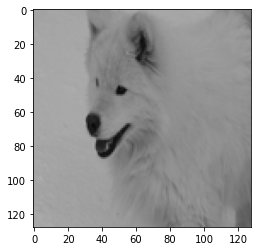

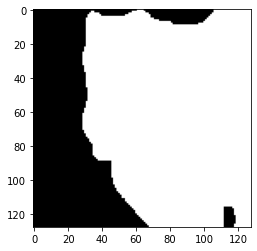

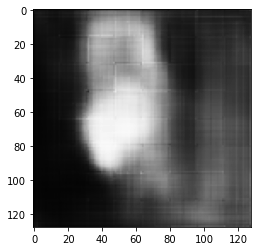

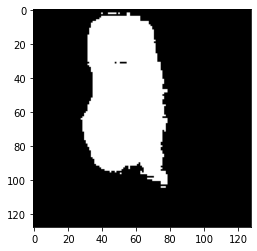

In [70]:
plt.imshow(test_ex_img, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX)
plt.show()
plt.imshow(test_ex_true * 255, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX)
plt.show()
plt.imshow(test_ex_pred * 255, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX)
plt.show()
plt.imshow((np.greater(test_ex_pred, cls_thresh)).astype(np.uint8) * 255, cmap="gray", vmin=defs.GS_MIN, vmax=defs.GS_MAX)
plt.show()